In [2]:
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import classification_report
import logging
import re
import nltk
import random
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

logging.basicConfig(level=logging.INFO)

class ImprovedAdComplaintFeatures:
    def __init__(self):
        # 重新设计的标签词典
        self.label_dict = {
            'misleading': {  # 标签1
                'primary': [
                    'misleading', 'false', 'incorrect', 'inaccurate', 'untrue',
                    'deceptive', 'misrepresent', 'exaggerate', 'misleads',
                    'unsubstantiated', 'wrong', 'dishonest', 'no proof',
                    'no evidence', 'claim', 'unclear', 'confusing'
                ],
                'phrases': [
                    'not true', 'false claim', 'misleading information',
                    'wrong information', 'cannot be substantiated',
                    'no scientific evidence', 'misleading comparison',
                    'not factual', 'factually incorrect'
                ]
            },
            'social_responsibility': {  # 标签2
                'primary': [
                    'unsafe', 'dangerous', 'harmful', 'irresponsible', 'hazard',
                    'risk', 'safety', 'health', 'alcohol', 'gambling', 'tobacco',
                    'addiction', 'accident', 'injury', 'public', 'society'
                ],
                'phrases': [
                    'social responsibility', 'public safety', 'health risk',
                    'safety concern', 'unsafe practice', 'dangerous behavior',
                    'public health', 'community concern', 'harmful effect',
                    'risk to public'
                ]
            },
            'placement': {  # 标签3
                'primary': [
                    'location', 'place', 'position', 'display', 'billboard',
                    'visible', 'screen', 'site', 'area', 'distance', 'near',
                    'close', 'proximity', 'street', 'road', 'outside'
                ],
                'phrases': [
                    'near school', 'close to', 'in front of', 'next to',
                    'wrong place', 'inappropriate location', 'public space',
                    'residential area', 'too close to', 'placement issue',
                    'visible from'
                ]
            },
            'children': {  # 标签4
                'primary': [
                    'child', 'children', 'kid', 'minor', 'young', 'youth',
                    'teen', 'teenage', 'student', 'school', 'parent', 'family',
                    'playground', 'juvenile', 'underage', 'baby', 'infant'
                ],
                'phrases': [
                    'target children', 'appeal to children', 'child safety',
                    'protect children', 'school area', 'young people',
                    'young audience', 'children content', 'kids zone',
                    'family viewing'
                ]
            },
            'taste_decency': {  # 标签5
                'primary': [
                    'offensive', 'inappropriate', 'vulgar', 'explicit', 'sexual',
                    'violent', 'disturbing', 'graphic', 'crude', 'tasteless',
                    'indecent', 'obscene', 'inappropriate', 'distasteful',
                    'provocative', 'uncomfortable'
                ],
                'phrases': [
                    'sexually suggestive', 'offensive content', 'bad taste',
                    'inappropriate content', 'adult content', 'mature content',
                    'explicit material', 'offensive language', 'disturbing image',
                    'sexual innuendo'
                ]
            }
        }

        # 标签映射词典 - 就在label_dict后面添加
        self.label_mapping = {
            'misleading': '1',
            'social_responsibility': '2',
            'placement': '3',
            'children': '4',
            'taste_decency': '5'
        }

        # 情感标记词典 (原有的代码)
        self.emotion_words = {
            'strong_negative': [
                'very', 'extremely', 'absolutely', 'totally', 'completely',
                'highly', 'seriously', 'strongly', 'deeply', 'gravely',
                'outrageous', 'unacceptable', 'inappropriate', 'disgusting'
            ],
            'concern': [
                'worry', 'concern', 'afraid', 'fear', 'alarming',
                'dangerous', 'risky', 'threat', 'problem', 'issue',
                'serious', 'severe', 'significant'
            ]
        }

    def clean_text(self, text):
        """改进的文本清理，保留更多有意义的标点和格式"""
        text = str(text).lower()
        # 保留更多标点符号和格式特征
        text = re.sub(r'[^a-z0-9\s!?.,-:;\'"()]', ' ', text)
        # 规范化空白字符
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def extract_phrase_features(self, text, phrases):
        """提取短语特征"""
        count = 0
        for phrase in phrases:
            count += text.count(phrase)
        return count
    def direct_keyword_classification(self, text):
        """
        直接基于关键词进行分类的方法
        返回包含标签的列表
        """
        text = self.clean_text(text)
        matched_labels = set()

        # 检查每个类别的关键词
        for category, word_sets in self.label_dict.items():
            # 检查主要关键词
            if any(word in text for word in word_sets['primary']):
                matched_labels.add(self.label_mapping[category])
                continue

            # 检查短语
            if any(phrase in text for phrase in word_sets['phrases']):
                matched_labels.add(self.label_mapping[category])

        # 如果没有匹配到任何标签，返回'0'（其他类别）
        return list(matched_labels) if matched_labels else ['0']

    def test_classification(self, text):
        """
        测试文本的关键词匹配结果
        """
        text = self.clean_text(text)
        results = {}

        for category, word_sets in self.label_dict.items():
            # 找到匹配的关键词
            matched_primary = [word for word in word_sets['primary'] if word in text]
            matched_phrases = [phrase for phrase in word_sets['phrases'] if phrase in text]

            if matched_primary or matched_phrases:
                results[self.label_mapping[category]] = {
                    'matched_keywords': matched_primary,
                    'matched_phrases': matched_phrases
                }

        return results

    def test_keyword_matching(self, text):
        """测试关键词匹配功能的便捷方法"""
        # 获取关键词分类结果
        labels = self.direct_keyword_classification(text)
        print("分类标签:", labels)

        # 获取详细匹配信息
        matches = self.test_classification(text)
        print("匹配详情:", matches)

        return labels, matches

    def extract_label_features(self, text):
        """提取标签相关特征"""
        text = self.clean_text(text)
        words = text.split()
        total_words = len(words) if words else 1

        features = {}

        for label, word_sets in self.label_dict.items():
            # 单词级别特征
            primary_count = sum(word in text for word in word_sets['primary'])
            # 短语级别特征
            phrase_count = self.extract_phrase_features(text, word_sets['phrases'])

            features.update({
                f'{label}_primary_count': primary_count,
                f'{label}_phrase_count': phrase_count,
                f'{label}_total_count': primary_count + phrase_count,
                f'{label}_density': (primary_count + phrase_count) / total_words,
                f'{label}_phrase_ratio': phrase_count / (primary_count + phrase_count + 1e-10)
            })

        return features

    def extract_emotion_features(self, text):
        """提取情感特征"""
        text = self.clean_text(text)
        words = text.split()
        total_words = len(words) if words else 1
        sentences = [s.strip() for s in text.split('.') if s.strip()]

        features = {}

        # 情感词特征
        for emotion, words_list in self.emotion_words.items():
            count = sum(word in text for word in words_list)
            features[f'{emotion}_count'] = count
            features[f'{emotion}_ratio'] = count / total_words

        # 标点符号特征
        features.update({
            'exclamation_density': text.count('!') / len(sentences) if sentences else 0,
            'question_density': text.count('?') / len(sentences) if sentences else 0,
            'emphasis_punctuation': (text.count('!') + text.count('?') + text.count('!!')) / len(sentences) if sentences else 0
        })

        # 大写字母特征（从原始文本提取）
        original_sentences = str(text).split('.')
        features['caps_sentence_ratio'] = sum(1 for s in original_sentences if any(c.isupper() for c in s)) / len(sentences) if sentences else 0

        return features

    def extract_structural_features(self, text):
        """提取结构特征"""
        text = str(text)
        sentences = [s.strip() for s in text.split('.') if s.strip()]
        words = text.split()

        return {
            'sentence_count': len(sentences),
            'avg_sentence_length': np.mean([len(s.split()) for s in sentences]) if sentences else 0,
            'max_sentence_length': max([len(s.split()) for s in sentences]) if sentences else 0,
            'min_sentence_length': min([len(s.split()) for s in sentences]) if sentences else 0,
            'word_count': len(words),
            'unique_word_ratio': len(set(words)) / len(words) if words else 0,
            'comma_per_sentence': sum(s.count(',') for s in sentences) / len(sentences) if sentences else 0
        }

    def create_features(self, df, text_column='complaints'):
        """生成所有特征"""
        logging.info("开始生成改进后的特征...")

        all_features = []
        for text in df[text_column]:
            features = {}

            # 合并所有特征
            features.update(self.extract_label_features(text))
            features.update(self.extract_emotion_features(text))
            features.update(self.extract_structural_features(text))

            # 添加关键词匹配结果作为独热编码特征
            keyword_matches = self.direct_keyword_classification(text)
            # 为每个可能的标签（0-5）创建一个二进制特征
            for i in range(6):  # 包括0标签
                features[f'keyword_match_{i}'] = 1 if str(i) in keyword_matches else 0

            all_features.append(features)

        features_df = pd.DataFrame(all_features)
        logging.info(f"特征生成完成。总特征数: {features_df.shape[1]}")

        return features_df

    def analyze_features(self, features_df, labels, top_n=20):
        """分析特征重要性"""
        from sklearn.ensemble import RandomForestClassifier

        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(features_df, labels)

        importance = pd.Series(
            rf.feature_importances_,
            index=features_df.columns
        ).sort_values(ascending=False)

        return {
            'top_features': importance.head(top_n),
            'feature_correlations': features_df.corr()
        }

class HybridDataset(Dataset):
    def __init__(self, texts, features, labels, tokenizer, max_length=512):
        self.texts = texts
        self.features = features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'features': torch.FloatTensor(self.features[idx]),
            'labels': torch.FloatTensor(self.labels[idx])
        }

class HybridBERTModel(nn.Module):
    def __init__(self, n_classes, n_features, bert_model='bert-base-uncased'):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model)

        # BERT输出维度 (768) + 手工特征维度
        combined_dim = self.bert.config.hidden_size + n_features

        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes),
            nn.Softmax(dim=1)  # 改为 Softmax，因为是单标签分类
        )

    def forward(self, input_ids, attention_mask, features):
        # BERT输出
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output

        # 连接BERT输出和手工特征
        combined_features = torch.cat((pooled_output, features), dim=1)

        # 分类
        return self.classifier(combined_features)
import nltk
import random
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import numpy as np

class TextAugmenter:
    def __init__(self, num_augmentations=2, p_synonym=0.3, p_back_translation=0.3):
        """
        Initialize TextAugmenter with configurable parameters.

        Args:
            num_augmentations (int): Number of augmented versions to generate per text
            p_synonym (float): Probability of applying synonym replacement
            p_back_translation (float): Probability of applying back translation
        """
        self.num_augmentations = num_augmentations
        self.p_synonym = p_synonym
        self.p_back_translation = p_back_translation

        # NLTK resources are downloaded at script startup
        pass

    def get_synonyms(self, word):
        """Get synonyms for a word using WordNet."""
        synonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.name() != word and '_' not in lemma.name():
                    synonyms.add(lemma.name())
        return list(synonyms)

    def synonym_replacement(self, text):
        """Replace random words with their synonyms."""
        words = word_tokenize(text)
        num_to_replace = max(1, int(len(words) * 0.15))  # Replace up to 15% of words

        # Get indices of words that have synonyms
        valid_indices = []
        for i, word in enumerate(words):
            if len(self.get_synonyms(word)) > 0:
                valid_indices.append(i)

        # Randomly select indices to replace
        if valid_indices:
            indices_to_replace = random.sample(valid_indices,
                                            min(num_to_replace, len(valid_indices)))

            for idx in indices_to_replace:
                synonyms = self.get_synonyms(words[idx])
                if synonyms:
                    words[idx] = random.choice(synonyms)

        return ' '.join(words)

    def word_deletion(self, text):
        """Randomly delete words from the text."""
        words = word_tokenize(text)
        if len(words) <= 3:  # Don't delete from very short texts
            return text

        num_to_delete = max(1, int(len(words) * 0.1))  # Delete up to 10% of words
        indices_to_delete = random.sample(range(len(words)), num_to_delete)

        return ' '.join([word for i, word in enumerate(words)
                        if i not in indices_to_delete])

    def augment(self, text):
        """Generate multiple augmented versions of the input text."""
        augmented_texts = []

        for _ in range(self.num_augmentations):
            aug_text = text

            # Apply synonym replacement
            if random.random() < self.p_synonym:
                aug_text = self.synonym_replacement(aug_text)

            # Apply word deletion
            if random.random() < 0.2:  # 20% chance of word deletion
                aug_text = self.word_deletion(aug_text)

            if aug_text != text:  # Only add if the text was actually modified
                augmented_texts.append(aug_text)

        return augmented_texts

def train_model(model, train_loader, val_loader, device, train_labels, epochs=5):
    # 使用 CrossEntropyLoss，适用于单标签分类
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)

            # 获取标签的索引（因为是单标签分类）
            labels = torch.argmax(labels, dim=1)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # 验证
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                features = batch['features'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask, features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        logging.info(f'Epoch {epoch+1}:')
        logging.info(f'Average training loss: {avg_train_loss:.4f}')
        logging.info(f'Average validation loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_hybrid_model.pt')
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)

            outputs = model(input_ids, attention_mask, features)
            # 获取预测的类别
            preds = torch.argmax(outputs, dim=1)

            # 获取真实标签的索引
            labels = torch.argmax(batch['labels'], dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 打印评估指标
    print("\n分类报告:")
    print(classification_report(
        all_labels,
        all_preds,
        digits=4
    ))

def prepare_labels(df):
    """
    将标签转换为单标签格式（只取第一个数字）
    参数：
        df: 包含 'label' 列的 DataFrame
    返回：
        label_matrix: one-hot编码的标签矩阵
        all_labels: 标签列表
    """
    # 提取第一个数字作为标签
    labels = df['label'].apply(lambda x: int(x.split(',')[0]))

    # 获取唯一标签值
    all_labels = sorted(labels.unique())

    # 创建 one-hot 编码矩阵
    label_matrix = np.zeros((len(df), len(all_labels)))
    for i, label in enumerate(labels):
        label_matrix[i, all_labels.index(label)] = 1

    return label_matrix, all_labels

def get_label_weights(label_matrix):
    pos_weights = len(label_matrix) / (np.sum(label_matrix, axis=0) + 1e-5)
    return torch.FloatTensor(pos_weights)
def main():
    # 读取数据
    df = pd.read_csv('/content/drive/MyDrive/combination_excel_withoutnull_labeled.csv')

    # 只保留需要的列并处理标签
    df = df[['complaint_id', 'complaints', 'label']]

    # 提取特征
    feature_engineer = ImprovedAdComplaintFeatures()
    features_df = feature_engineer.create_features(df)

    # 标准化特征
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_df)

    # 准备标签（单标签）
    labels, all_labels = prepare_labels(df)

    # 分割数据（移除 stratify 参数，因为可能有类别样本太少）
    X_train, X_test, y_train, y_test, f_train, f_test = train_test_split(
        df['complaints'].values,
        labels,
        features_scaled,
        test_size=0.2,
        random_state=42
    )

    # 初始化 text augmenter
    augmenter = TextAugmenter()

    # 数据增强
    logging.info("正在进行数据增强...")
    X_train_aug, y_train_aug, f_train_aug = augment_training_data(
        X_train, y_train, f_train, augmenter
    )

    # 初始化tokenizer和数据加载器
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_dataset = HybridDataset(X_train_aug, f_train_aug, y_train_aug, tokenizer)
    test_dataset = HybridDataset(X_test, f_test, y_test, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # 初始化模型
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HybridBERTModel(
        n_classes=len(all_labels),  # 使用实际的标签数量
        n_features=features_scaled.shape[1]
    ).to(device)

    # 训练模型
    train_model(model, train_loader, test_loader, device, y_train_aug)

    # 评估模型
    evaluate_model(model, test_loader, device)

if __name__ == "__main__":
    main()


分类报告:
              precision    recall  f1-score   support

           0     0.7600    0.9127    0.8294       229
           1     0.9032    0.7865    0.8408       178
           2     0.8571    0.7853    0.8197       191
           3     0.9259    0.3289    0.4854        76
           4     0.7419    0.6970    0.7188        99
           5     0.6905    0.8951    0.7796       162

    accuracy                         0.7893       935
   macro avg     0.8131    0.7342    0.7456       935
weighted avg     0.8066    0.7893    0.7813       935



In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import classification_report
import logging
import re
import nltk
import random
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

logging.basicConfig(level=logging.INFO)

class ImprovedAdComplaintFeatures:
    def __init__(self):
        # 重新设计的标签词典
        self.label_dict = {
            'misleading': {  # 标签1
                'primary': [
                    'misleading', 'false', 'incorrect', 'inaccurate', 'untrue',
                    'deceptive', 'misrepresent', 'exaggerate', 'misleads',
                    'unsubstantiated', 'wrong', 'dishonest', 'no proof',
                    'no evidence', 'claim', 'unclear', 'confusing'
                ],
                'phrases': [
                    'not true', 'false claim', 'misleading information',
                    'wrong information', 'cannot be substantiated',
                    'no scientific evidence', 'misleading comparison',
                    'not factual', 'factually incorrect'
                ]
            },
            'social_responsibility': {  # 标签2
                'primary': [
                    'unsafe', 'dangerous', 'harmful', 'irresponsible', 'hazard',
                    'risk', 'safety', 'health', 'alcohol', 'gambling', 'tobacco',
                    'addiction', 'accident', 'injury', 'public', 'society'
                ],
                'phrases': [
                    'social responsibility', 'public safety', 'health risk',
                    'safety concern', 'unsafe practice', 'dangerous behavior',
                    'public health', 'community concern', 'harmful effect',
                    'risk to public'
                ]
            },
            'placement': {  # 标签3
                'primary': [
                    'location', 'place', 'position', 'display', 'billboard',
                    'visible', 'screen', 'site', 'area', 'distance', 'near',
                    'close', 'proximity', 'street', 'road', 'outside'
                ],
                'phrases': [
                    'near school', 'close to', 'in front of', 'next to',
                    'wrong place', 'inappropriate location', 'public space',
                    'residential area', 'too close to', 'placement issue',
                    'visible from'
                ]
            },
            'children': {  # 标签4
                'primary': [
                    'child', 'children', 'kid', 'minor', 'young', 'youth',
                    'teen', 'teenage', 'student', 'school', 'parent', 'family',
                    'playground', 'juvenile', 'underage', 'baby', 'infant'
                ],
                'phrases': [
                    'target children', 'appeal to children', 'child safety',
                    'protect children', 'school area', 'young people',
                    'young audience', 'children content', 'kids zone',
                    'family viewing'
                ]
            },
            'taste_decency': {  # 标签5
                'primary': [
                    'offensive', 'inappropriate', 'vulgar', 'explicit', 'sexual',
                    'violent', 'disturbing', 'graphic', 'crude', 'tasteless',
                    'indecent', 'obscene', 'inappropriate', 'distasteful',
                    'provocative', 'uncomfortable'
                ],
                'phrases': [
                    'sexually suggestive', 'offensive content', 'bad taste',
                    'inappropriate content', 'adult content', 'mature content',
                    'explicit material', 'offensive language', 'disturbing image',
                    'sexual innuendo'
                ]
            }
        }

        # 标签映射词典 - 就在label_dict后面添加
        self.label_mapping = {
            'misleading': '1',
            'social_responsibility': '2',
            'placement': '3',
            'children': '4',
            'taste_decency': '5'
        }

        # 情感标记词典 (原有的代码)
        self.emotion_words = {
            'strong_negative': [
                'very', 'extremely', 'absolutely', 'totally', 'completely',
                'highly', 'seriously', 'strongly', 'deeply', 'gravely',
                'outrageous', 'unacceptable', 'inappropriate', 'disgusting'
            ],
            'concern': [
                'worry', 'concern', 'afraid', 'fear', 'alarming',
                'dangerous', 'risky', 'threat', 'problem', 'issue',
                'serious', 'severe', 'significant'
            ]
        }

    def clean_text(self, text):
        """改进的文本清理，保留更多有意义的标点和格式"""
        text = str(text).lower()
        # 保留更多标点符号和格式特征
        text = re.sub(r'[^a-z0-9\s!?.,-:;\'"()]', ' ', text)
        # 规范化空白字符
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def extract_phrase_features(self, text, phrases):
        """提取短语特征"""
        count = 0
        for phrase in phrases:
            count += text.count(phrase)
        return count
    def direct_keyword_classification(self, text):
        """
        直接基于关键词进行分类的方法
        返回包含标签的列表
        """
        text = self.clean_text(text)
        matched_labels = set()

        # 检查每个类别的关键词
        for category, word_sets in self.label_dict.items():
            # 检查主要关键词
            if any(word in text for word in word_sets['primary']):
                matched_labels.add(self.label_mapping[category])
                continue

            # 检查短语
            if any(phrase in text for phrase in word_sets['phrases']):
                matched_labels.add(self.label_mapping[category])

        # 如果没有匹配到任何标签，返回'0'（其他类别）
        return list(matched_labels) if matched_labels else ['0']

    def test_classification(self, text):
        """
        测试文本的关键词匹配结果
        """
        text = self.clean_text(text)
        results = {}

        for category, word_sets in self.label_dict.items():
            # 找到匹配的关键词
            matched_primary = [word for word in word_sets['primary'] if word in text]
            matched_phrases = [phrase for phrase in word_sets['phrases'] if phrase in text]

            if matched_primary or matched_phrases:
                results[self.label_mapping[category]] = {
                    'matched_keywords': matched_primary,
                    'matched_phrases': matched_phrases
                }

        return results

    def test_keyword_matching(self, text):
        """测试关键词匹配功能的便捷方法"""
        # 获取关键词分类结果
        labels = self.direct_keyword_classification(text)
        print("分类标签:", labels)

        # 获取详细匹配信息
        matches = self.test_classification(text)
        print("匹配详情:", matches)

        return labels, matches

    def extract_label_features(self, text):
        """提取标签相关特征"""
        text = self.clean_text(text)
        words = text.split()
        total_words = len(words) if words else 1

        features = {}

        for label, word_sets in self.label_dict.items():
            # 单词级别特征
            primary_count = sum(word in text for word in word_sets['primary'])
            # 短语级别特征
            phrase_count = self.extract_phrase_features(text, word_sets['phrases'])

            features.update({
                f'{label}_primary_count': primary_count,
                f'{label}_phrase_count': phrase_count,
                f'{label}_total_count': primary_count + phrase_count,
                f'{label}_density': (primary_count + phrase_count) / total_words,
                f'{label}_phrase_ratio': phrase_count / (primary_count + phrase_count + 1e-10)
            })

        return features

    def extract_emotion_features(self, text):
        """提取情感特征"""
        text = self.clean_text(text)
        words = text.split()
        total_words = len(words) if words else 1
        sentences = [s.strip() for s in text.split('.') if s.strip()]

        features = {}

        # 情感词特征
        for emotion, words_list in self.emotion_words.items():
            count = sum(word in text for word in words_list)
            features[f'{emotion}_count'] = count
            features[f'{emotion}_ratio'] = count / total_words

        # 标点符号特征
        features.update({
            'exclamation_density': text.count('!') / len(sentences) if sentences else 0,
            'question_density': text.count('?') / len(sentences) if sentences else 0,
            'emphasis_punctuation': (text.count('!') + text.count('?') + text.count('!!')) / len(sentences) if sentences else 0
        })

        # 大写字母特征（从原始文本提取）
        original_sentences = str(text).split('.')
        features['caps_sentence_ratio'] = sum(1 for s in original_sentences if any(c.isupper() for c in s)) / len(sentences) if sentences else 0

        return features

    def extract_structural_features(self, text):
        """提取结构特征"""
        text = str(text)
        sentences = [s.strip() for s in text.split('.') if s.strip()]
        words = text.split()

        return {
            'sentence_count': len(sentences),
            'avg_sentence_length': np.mean([len(s.split()) for s in sentences]) if sentences else 0,
            'max_sentence_length': max([len(s.split()) for s in sentences]) if sentences else 0,
            'min_sentence_length': min([len(s.split()) for s in sentences]) if sentences else 0,
            'word_count': len(words),
            'unique_word_ratio': len(set(words)) / len(words) if words else 0,
            'comma_per_sentence': sum(s.count(',') for s in sentences) / len(sentences) if sentences else 0
        }

    def create_features(self, df, text_column='complaints'):
        """生成所有特征"""
        logging.info("开始生成改进后的特征...")

        all_features = []
        for text in df[text_column]:
            features = {}

            # 合并所有特征
            features.update(self.extract_label_features(text))
            features.update(self.extract_emotion_features(text))
            features.update(self.extract_structural_features(text))

            # 添加关键词匹配结果作为独热编码特征
            keyword_matches = self.direct_keyword_classification(text)
            # 为每个可能的标签（0-5）创建一个二进制特征
            for i in range(6):  # 包括0标签
                features[f'keyword_match_{i}'] = 1 if str(i) in keyword_matches else 0

            all_features.append(features)

        features_df = pd.DataFrame(all_features)
        logging.info(f"特征生成完成。总特征数: {features_df.shape[1]}")

        return features_df

    def analyze_features(self, features_df, labels, top_n=20):
        """分析特征重要性"""
        from sklearn.ensemble import RandomForestClassifier

        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(features_df, labels)

        importance = pd.Series(
            rf.feature_importances_,
            index=features_df.columns
        ).sort_values(ascending=False)

        return {
            'top_features': importance.head(top_n),
            'feature_correlations': features_df.corr()
        }

class HybridDataset(Dataset):
    def __init__(self, texts, features, labels, tokenizer, max_length=512):
        self.texts = texts
        self.features = features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'features': torch.FloatTensor(self.features[idx]),
            'labels': torch.FloatTensor(self.labels[idx])
        }

class HybridBERTModel(nn.Module):
    def __init__(self, n_classes, n_features, bert_model='bert-base-uncased'):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model)

        # BERT输出维度 (768) + 手工特征维度
        combined_dim = self.bert.config.hidden_size + n_features

        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes),
            nn.Softmax(dim=1)  # 改为 Softmax，因为是单标签分类
        )

    def forward(self, input_ids, attention_mask, features):
        # BERT输出
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output

        # 连接BERT输出和手工特征
        combined_features = torch.cat((pooled_output, features), dim=1)

        # 分类
        return self.classifier(combined_features)
import nltk
import random
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import numpy as np

class TextAugmenter:
    def __init__(self, num_augmentations=2, p_synonym=0.3, p_back_translation=0.3):
        """
        Initialize TextAugmenter with configurable parameters.

        Args:
            num_augmentations (int): Number of augmented versions to generate per text
            p_synonym (float): Probability of applying synonym replacement
            p_back_translation (float): Probability of applying back translation
        """
        self.num_augmentations = num_augmentations
        self.p_synonym = p_synonym
        self.p_back_translation = p_back_translation

        # NLTK resources are downloaded at script startup
        pass

    def get_synonyms(self, word):
        """Get synonyms for a word using WordNet."""
        synonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.name() != word and '_' not in lemma.name():
                    synonyms.add(lemma.name())
        return list(synonyms)

    def synonym_replacement(self, text):
        """Replace random words with their synonyms."""
        words = word_tokenize(text)
        num_to_replace = max(1, int(len(words) * 0.15))  # Replace up to 15% of words

        # Get indices of words that have synonyms
        valid_indices = []
        for i, word in enumerate(words):
            if len(self.get_synonyms(word)) > 0:
                valid_indices.append(i)

        # Randomly select indices to replace
        if valid_indices:
            indices_to_replace = random.sample(valid_indices,
                                            min(num_to_replace, len(valid_indices)))

            for idx in indices_to_replace:
                synonyms = self.get_synonyms(words[idx])
                if synonyms:
                    words[idx] = random.choice(synonyms)

        return ' '.join(words)

    def word_deletion(self, text):
        """Randomly delete words from the text."""
        words = word_tokenize(text)
        if len(words) <= 3:  # Don't delete from very short texts
            return text

        num_to_delete = max(1, int(len(words) * 0.1))  # Delete up to 10% of words
        indices_to_delete = random.sample(range(len(words)), num_to_delete)

        return ' '.join([word for i, word in enumerate(words)
                        if i not in indices_to_delete])

    def augment(self, text):
        """Generate multiple augmented versions of the input text."""
        augmented_texts = []

        for _ in range(self.num_augmentations):
            aug_text = text

            # Apply synonym replacement
            if random.random() < self.p_synonym:
                aug_text = self.synonym_replacement(aug_text)

            # Apply word deletion
            if random.random() < 0.2:  # 20% chance of word deletion
                aug_text = self.word_deletion(aug_text)

            if aug_text != text:  # Only add if the text was actually modified
                augmented_texts.append(aug_text)

        return augmented_texts

def train_model(model, train_loader, val_loader, device, train_labels, epochs=5):
    # 使用 CrossEntropyLoss，适用于单标签分类
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)

            # 获取标签的索引（因为是单标签分类）
            labels = torch.argmax(labels, dim=1)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # 验证
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                features = batch['features'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask, features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        logging.info(f'Epoch {epoch+1}:')
        logging.info(f'Average training loss: {avg_train_loss:.4f}')
        logging.info(f'Average validation loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_hybrid_model.pt')

def prepare_labels(df):
    """
    将标签转换为单标签格式（只取第一个数字）
    参数：
        df: 包含 'label' 列的 DataFrame
    返回：
        label_matrix: one-hot编码的标签矩阵
        all_labels: 标签列表
    """
    # 提取第一个数字作为标签
    labels = df['label'].apply(lambda x: int(x.split(',')[0]))

    # 获取唯一标签值
    all_labels = sorted(labels.unique())

    # 创建 one-hot 编码矩阵
    label_matrix = np.zeros((len(df), len(all_labels)))
    for i, label in enumerate(labels):
        label_matrix[i, all_labels.index(label)] = 1

    return label_matrix, all_labels

def get_label_weights(label_matrix):
    pos_weights = len(label_matrix) / (np.sum(label_matrix, axis=0) + 1e-5)
    return torch.FloatTensor(pos_weights)



from sklearn.model_selection import KFold

def main():
    # 读取数据
    df = pd.read_csv('/content/drive/MyDrive/combination_excel_withoutnull_labeled.csv')

    # 只保留需要的列并处理标签
    df = df[['complaint_id', 'complaints', 'label']]

    # 提取特征
    feature_engineer = ImprovedAdComplaintFeatures()
    features_df = feature_engineer.create_features(df)

    # 标准化特征
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_df)

    # 准备标签（单标签）
    labels, all_labels = prepare_labels(df)

    # 初始化 5-fold 交叉验证
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_results = []

    # 对每个fold进行训练和评估
    for fold, (train_idx, val_idx) in enumerate(kfold.split(df['complaints'].values)):
        logging.info(f"\n开始训练 Fold {fold + 1}/5")

        # 分割数据
        X_train, X_val = df['complaints'].values[train_idx], df['complaints'].values[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        f_train, f_val = features_scaled[train_idx], features_scaled[val_idx]

        # 初始化 text augmenter
        augmenter = TextAugmenter()

        # 数据增强
        logging.info(f"Fold {fold + 1}: 正在进行数据增强...")
        X_train_aug, y_train_aug, f_train_aug = augment_training_data(
            X_train, y_train, f_train, augmenter
        )

        # 初始化tokenizer和数据加载器
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        train_dataset = HybridDataset(X_train_aug, f_train_aug, y_train_aug, tokenizer)
        val_dataset = HybridDataset(X_val, f_val, y_val, tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16)

        # 初始化模型
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = HybridBERTModel(
            n_classes=len(all_labels),
            n_features=features_scaled.shape[1]
        ).to(device)

        # 训练模型
        train_model(model, train_loader, val_loader, device, y_train_aug)

        # 评估当前fold的模型
        logging.info(f"评估 Fold {fold + 1} 的结果:")
        fold_result = evaluate_model(model, val_loader, device)
        fold_results.append(fold_result)

        # 保存每个fold的模型
        torch.save(model.state_dict(), f'best_hybrid_model_fold_{fold+1}.pt')

    # 计算并输出平均结果
    logging.info("\n所有Fold的平均结果:")
    # 这里需要修改evaluate_model函数来返回具体的指标值，以便计算平均值

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)

            outputs = model(input_ids, attention_mask, features)
            preds = torch.argmax(outputs, dim=1)
            labels = torch.argmax(batch['labels'], dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 计算评估指标
    report = classification_report(
        all_labels,
        all_preds,
        digits=4,
        output_dict=True  # 返回字典格式，便于后续计算平均值
    )

    # 打印当前fold的结果
    print("\n分类报告:")
    print(classification_report(all_labels, all_preds, digits=4))

    return report
def augment_training_data(X_train, y_train, f_train, augmenter):
    """
    使用文本增强技术来增强训练数据

    参数：
        X_train: 原始训练文本
        y_train: 原始训练标签（one-hot编码）
        f_train: 原始训练特征
        augmenter: TextAugmenter实例

    返回：
        元组 (augmented_texts, augmented_labels, augmented_features)
    """
    augmented_texts = []
    augmented_labels = []
    augmented_features = []

    # 首先添加原始数据
    augmented_texts.extend(X_train)
    augmented_labels.extend(y_train)
    augmented_features.extend(f_train)

    # 然后添加增强版本
    for idx, (text, label, features) in enumerate(zip(X_train, y_train, f_train)):
        # 获取文本的增强版本
        aug_versions = augmenter.augment(text)

        # 为每个增强版本添加相应的标签和特征
        for aug_text in aug_versions:
            augmented_texts.append(aug_text)
            augmented_labels.append(label)  # 使用原始标签
            augmented_features.append(features)  # 使用原始特征

    # 转换为numpy数组
    return (
        np.array(augmented_texts),
        np.array(augmented_labels),
        np.array(augmented_features)
    )

def main():
    # 读取数据
    df = pd.read_csv('/content/drive/MyDrive/combination_excel_withoutnull_labeled.csv')

    # 只保留需要的列并处理标签
    df = df[['complaint_id', 'complaints', 'label']]

    # 提取特征
    feature_engineer = ImprovedAdComplaintFeatures()
    features_df = feature_engineer.create_features(df)

    # 标准化特征
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_df)

    # 准备标签（单标签）
    labels, all_labels = prepare_labels(df)

    # 初始化 5-fold 交叉验证
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_results = []

    # 对每个fold进行训练和评估
    for fold, (train_idx, val_idx) in enumerate(kfold.split(df['complaints'].values)):
        logging.info(f"\n开始训练 Fold {fold + 1}/5")

        # 分割数据
        X_train, X_val = df['complaints'].values[train_idx], df['complaints'].values[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        f_train, f_val = features_scaled[train_idx], features_scaled[val_idx]

        # 初始化 text augmenter
        augmenter = TextAugmenter()

        # 数据增强
        logging.info(f"Fold {fold + 1}: 正在进行数据增强...")
        X_train_aug, y_train_aug, f_train_aug = augment_training_data(
            X_train, y_train, f_train, augmenter
        )

        # 初始化tokenizer和数据加载器
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        train_dataset = HybridDataset(X_train_aug, f_train_aug, y_train_aug, tokenizer)
        val_dataset = HybridDataset(X_val, f_val, y_val, tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16)

        # 初始化模型
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = HybridBERTModel(
            n_classes=len(all_labels),
            n_features=features_scaled.shape[1]
        ).to(device)

        # 训练模型
        train_model(model, train_loader, val_loader, device, y_train_aug)

        # 评估当前fold的模型
        logging.info(f"评估 Fold {fold + 1} 的结果:")
        fold_result = evaluate_model(model, val_loader, device)
        fold_results.append(fold_result)

        # 保存每个fold的模型
        torch.save(model.state_dict(), f'best_hybrid_model_fold_{fold+1}.pt')

    # 计算并输出平均结果
    logging.info("\n所有Fold的平均结果:")


if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


分类报告:
              precision    recall  f1-score   support

           0     0.7480    0.8166    0.7808       229
           1     0.8304    0.7978    0.8138       178
           2     0.7857    0.8063    0.7959       191
           3     0.8929    0.3289    0.4808        76
           4     0.6636    0.7172    0.6893        99
           5     0.7213    0.8148    0.7652       162

    accuracy                         0.7604       935
   macro avg     0.7736    0.7136    0.7210       935
weighted avg     0.7696    0.7604    0.7534       935


分类报告:
              precision    recall  f1-score   support

           0     0.7323    0.8230    0.7750       226
           1     0.8462    0.7500    0.7952       176
           2     0.8258    0.7111    0.7642       180
           3     0.9714    0.3696    0.5354        92
           4     0.7053    0.6700    0.6872       100
           5     0.6167    0.9193    0.7382       161

    accuracy                         0.7433       935
   macro 

In [2]:
import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import json
from datetime import datetime
import uuid
from tqdm import tqdm
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def extract_all_feature_names():
    """提取所有可能的特征名称"""
    # 基础标签类别
    base_categories = ['misleading', 'social_responsibility', 'placement',
                      'children', 'taste_decency']

    # 为每个类别生成特征名称
    feature_names = []

    # 标签相关特征
    for category in base_categories:
        feature_names.extend([
            f'{category}_primary_count',
            f'{category}_phrase_count',
            f'{category}_total_count',
            f'{category}_density',
            f'{category}_phrase_ratio'
        ])

    # 情感特征
    emotion_types = ['strong_negative', 'concern']
    for emotion in emotion_types:
        feature_names.extend([
            f'{emotion}_count',
            f'{emotion}_ratio'
        ])

    # 结构特征
    structural_features = [
        'sentence_count',
        'avg_sentence_length',
        'max_sentence_length',
        'min_sentence_length',
        'word_count',
        'unique_word_ratio',
        'comma_per_sentence',
        'exclamation_density',
        'question_density',
        'emphasis_punctuation',
        'caps_sentence_ratio'
    ]
    feature_names.extend(structural_features)

    # 关键词匹配特征
    for i in range(6):  # 0-5的标签
        feature_names.append(f'keyword_match_{i}')

    return feature_names

class ComplaintDataset(Dataset):
    def __init__(self, texts, features, tokenizer, max_length=512):
        self.texts = texts
        self.features = features
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'features': torch.FloatTensor(self.features[idx])
        }

def load_models(model_paths, device, n_classes, n_features):
    models = []

    # 记录第一个模型的特征维度
    first_model = True
    expected_feature_dim = None

    for path in model_paths:
        try:
            # 使用weights_only=True来避免警告
            state_dict = torch.load(path, map_location='cpu', weights_only=True)

            # 获取特征维度
            feature_dim = state_dict['classifier.0.weight'].shape[1] - 768

            if first_model:
                expected_feature_dim = feature_dim
                first_model = False
            else:
                assert feature_dim == expected_feature_dim, f"Feature dimension mismatch in {path}"

            model = HybridBERTModel(n_classes=n_classes, n_features=feature_dim)
            model.load_state_dict(state_dict)
            model.to(device)
            model.eval()
            models.append(model)
            logger.info(f"Successfully loaded model from {path} with feature dim {feature_dim}")
        except Exception as e:
            logger.error(f"Error loading model from {path}: {str(e)}")
            raise

    return models, expected_feature_dim

def predict_with_models(models, dataloader, device):
    all_predictions = []

    for model in models:
        model_predictions = []
        for batch in tqdm(dataloader, desc="Processing batches"):
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                features = batch['features'].to(device)

                with torch.no_grad():
                    outputs = model(input_ids, attention_mask, features)
                    predictions = outputs.cpu().numpy()
                model_predictions.extend(predictions)
            except Exception as e:
                logger.error(f"Error processing batch: {str(e)}")
                raise

        all_predictions.append(np.array(model_predictions))

    final_predictions = np.mean(all_predictions, axis=0)
    return final_predictions

def create_features(df, expected_feature_names=None):
    """创建特征，确保维度匹配"""
    feature_engineer = ImprovedAdComplaintFeatures()
    features_df = feature_engineer.create_features(df)

    # 如果没有提供预期特征名称，则获取所有可能的特征名称
    if expected_feature_names is None:
        expected_feature_names = extract_all_feature_names()

    logger.info(f"Expected features: {len(expected_feature_names)}")
    logger.info(f"Current features: {len(features_df.columns)}")

    # 确保所有预期的特征都存在
    for col in expected_feature_names:
        if col not in features_df.columns:
            logger.warning(f"Adding missing feature: {col}")
            features_df[col] = 0

    # 只选择预期的特征，并按预期顺序排列
    features_df = features_df[expected_feature_names]

    logger.info(f"Final feature shape: {features_df.shape}")
    return features_df

def create_json_output(df, predictions, start_time):
    """创建JSON输出"""
    category_mapping = {
        0: "misleading",
        1: "social responsibility",
        2: "placement",
        3: "children issues",
        4: "taste and decency",
        5: "other"
    }

    results = []
    for idx, row in df.iterrows():
        prediction = predictions[idx]
        # 获取top 4的预测结果
        top_indices = np.argsort(prediction)[-4:][::-1]

        analysis_results = [
            {
                "category": category_mapping[idx],
                "confidence": float(prediction[idx])
            }
            for idx in top_indices
        ]

        result = {
            "request_id": str(row['complaint_id']),  # 使用 complaint_id
            "status": "success",
            "timestamp": datetime.now().isoformat(),
            "data": {
                "content_id": f"text_{uuid.uuid4().hex[:8]}",
                "content": row['complaints'],
                "analysis_results": analysis_results,
                "metadata": {
                    "model_version": "bert-base-uncased-v1.0",
                    "processing_time": f"{int((datetime.now() - start_time).total_seconds() * 1000)}ms",
                    "language": "eng",
                    "word_count": len(row['complaints'].split())
                },
                "complaint_number": row['complaint_number'],
                "advertiser": row['advertiser'],
                "advertisement": row['advertisement'],
                "date_of_meeting": row['date_of_meeting'],
                "adver_id": row['adver_id'],
                "adver":row['adver_'],
                "adver_type": row['adver_type']
            }
        }
        results.append(result)

    return results

def main():
    try:
        logger.info("Starting complaint analysis process...")

        # 设置设备
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {device}")

        # 加载数据
        df = pd.read_csv('/Users/niwenyu/Desktop/OCR_PDF_EXTRACT/combination_excel_withoutnull_labeled_forjson.csv')
        logger.info(f"Loaded {len(df)} records from CSV")

        # 加载第一个模型来获取特征维度
        model_paths = [
            '/Users/niwenyu/Desktop/OCR_PDF_EXTRACT/best_model/best_hybrid_model_fold_1 .pt',
            '/Users/niwenyu/Desktop/OCR_PDF_EXTRACT/best_model/best_hybrid_model_fold_2.pt',
            '/Users/niwenyu/Desktop/OCR_PDF_EXTRACT/best_model/best_hybrid_model_fold_3.pt',
            '/Users/niwenyu/Desktop/OCR_PDF_EXTRACT/best_model/best_hybrid_model_fold_4.pt',
            '/Users/niwenyu/Desktop/OCR_PDF_EXTRACT/best_model/best_hybrid_model_fold_5.pt'
        ]

        # 加载模型并获取特征维度
        models, feature_dim = load_models(
            [model_paths[0]],  # 先只加载第一个模型
            device,
            n_classes=6,
            n_features=None  # 这里不需要指定，会从模型中获取
        )

        # 生成特征
        expected_feature_names = extract_all_feature_names()
        features_df = create_features(df, expected_feature_names)

        # 验证特征维度
        assert features_df.shape[1] == feature_dim, \
            f"Feature dimension mismatch: got {features_df.shape[1]}, expected {feature_dim}"

        # 标准化特征
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features_df)

        # 加载所有模型
        models, _ = load_models(
            model_paths,
            device,
            n_classes=6,
            n_features=feature_dim
        )

        # 初始化tokenizer和数据加载器
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        dataset = ComplaintDataset(df['complaints'].values, features_scaled, tokenizer)
        dataloader = DataLoader(dataset, batch_size=16)

        start_time = datetime.now()

        # 进行预测
        predictions = predict_with_models(models, dataloader, device)

        # 生成JSON输出
        results = create_json_output(df, predictions, start_time)

        # 保存结果
        output_file = 'complaint_analysis_results.json'
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(results, f, ensure_ascii=False, indent=2)

        logger.info(f"Successfully processed {len(results)} records")
        logger.info(f"Results saved to {output_file}")

    except Exception as e:
        logger.error(f"Error during processing: {str(e)}", exc_info=True)
        raise

if __name__ == "__main__":
    main()

INFO:__main__:Starting complaint analysis process...
INFO:__main__:Using device: cpu
INFO:__main__:Loaded 1874 records from CSV
ERROR:__main__:Error loading model from /Users/niwenyu/Desktop/OCR_PDF_EXTRACT/best_model/best_hybrid_model_fold_1 .pt: name 'HybridBERTModel' is not defined
ERROR:__main__:Error during processing: name 'HybridBERTModel' is not defined
Traceback (most recent call last):
  File "/var/folders/hw/p2gkv4651zl5pzcfg3b974_h0000gn/T/ipykernel_38938/610399886.py", line 247, in main
    models, feature_dim = load_models(
  File "/var/folders/hw/p2gkv4651zl5pzcfg3b974_h0000gn/T/ipykernel_38938/610399886.py", line 113, in load_models
    model = HybridBERTModel(n_classes=n_classes, n_features=feature_dim)
NameError: name 'HybridBERTModel' is not defined


NameError: name 'HybridBERTModel' is not defined

In [4]:
import json
import pandas as pd

def merge_json_csv(json_path, csv_path, output_path):
    # Read JSON file
    with open(json_path, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    
    # Read CSV file
    df = pd.read_csv(csv_path)
    
    # Create a dictionary for quick lookup of adver_ values
    adver_dict = pd.Series(df.adver_.values, index=df.complaint_number).to_dict()
    
    # Update JSON data with adver_ values
    for item in json_data:
        complaint_number = item['data']['complaint_number']
        # Add adver_ to each record
        item['data']['adver_'] = adver_dict.get(complaint_number, None)
    
    # Save updated JSON
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(json_data, f, ensure_ascii=False, indent=2)
    
    print(f"Successfully processed {len(json_data)} records")
    return json_data

# Example usage:
if __name__ == "__main__":
    json_path = "/Users/niwenyu/Desktop/OCR_PDF_EXTRACT/complaint_analysis_results (1).json"
    csv_path = "/Users/niwenyu/Desktop/OCR_PDF_EXTRACT/combination_excel_withoutnull_labeled_forjson.csv"
    output_path = "/Users/niwenyu/Desktop/OCR_PDF_EXTRACT/complaint_analysis_results (1).json"
    
    merged_data = merge_json_csv(json_path, csv_path, output_path)
    
    # Print a sample record to verify
    print("\nSample record from merged data:")
    print(json.dumps(merged_data[0], indent=2, ensure_ascii=False))

Successfully processed 1874 records

Sample record from merged data:
{
  "request_id": "20001",
  "status": "success",
  "timestamp": "2025-01-20T11:19:45.064996",
  "data": {
    "content_id": "text_1fab38f5",
    "content": "This complaint r elates to an alcohol advertisement for Effen Vodka| placed on a billboard |located on the corner of Onslow and Sandringham Roads in Kingsland| Auckland. The |billboard is located directly opposite Kowhai Intermediate School located at 26 Onslow Rd| |occupying the other corner of Onslow and Sandringham Roads. Photographs of the billboard |are appended. |Principle 3 of the Code for Advertising and Promotion of Alcohol states: |Alcohol advertising and promotions shall be directed at adult audiences. Alcohol advertis ing |and promotions shall not be directed at minors nor have strong or evident appeal to minors in |particular. This applies to both content and placement. |Given the placement of the billboard in very close proximity to Kowhai Intermedi

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# cluster

Checking data quality...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Getting BERT embeddings...


100%|██████████| 59/59 [00:12<00:00,  4.84it/s]



Finding optimal number of clusters...
Clusters: 2, Silhouette Score: 0.114
Clusters: 3, Silhouette Score: 0.088
Clusters: 4, Silhouette Score: 0.073
Clusters: 5, Silhouette Score: 0.071
Clusters: 6, Silhouette Score: 0.070
Clusters: 7, Silhouette Score: 0.062
Clusters: 8, Silhouette Score: 0.062
Clusters: 9, Silhouette Score: 0.053
Clusters: 10, Silhouette Score: 0.056

Optimal number of clusters: 2

Extracting cluster keywords...

Cluster 1 keywords: ad, advertisement, advertising, people, advert, would, also, health, 2, misleading
Sample complaints from this cluster:
- This complaint r elates to an alcohol advertisement for Effen Vodka| placed on a billboard |located on the corner of Onslow and Sandringham Roads in Kingsland| Auckland. The |billboard is located dire...
- Complaint Details: The unsaid campaign I believe attempts to circumvent transparency by h aving a silent ad with no clear audible authorised by "NZTA" for example at the end. To me, it is a clear atte...
- This vide

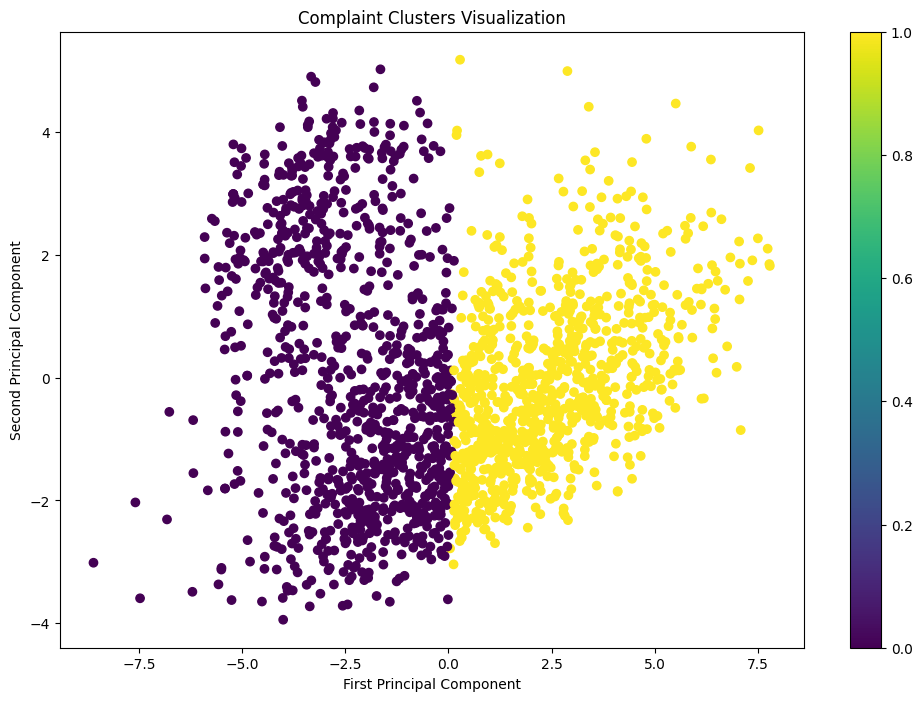


Saved results to 'complaints_with_clusters.csv'


In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

class ComplaintAnalyzer:
    def __init__(self, bert_model='bert-base-uncased'):
        self.tokenizer = BertTokenizer.from_pretrained(bert_model)
        self.model = BertModel.from_pretrained(bert_model)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()

        # 下载停用词
        nltk.download('stopwords')
        nltk.download('punkt')
        self.stop_words = set(stopwords.words('english'))

    def get_embeddings(self, texts, batch_size=32):
        embeddings = []

        # 预处理文本，确保所有输入都是字符串类型
        processed_texts = []
        for text in texts:
            # 处理空值和非字符串类型
            if pd.isna(text):
                processed_texts.append("")  # 空值转换为空字符串
            else:
                processed_texts.append(str(text))  # 确保是字符串类型

        for i in tqdm(range(0, len(processed_texts), batch_size)):
            batch_texts = processed_texts[i:i + batch_size]
            encoded = self.tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors='pt'
            ).to(self.device)

            with torch.no_grad():
                outputs = self.model(**encoded)
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.extend(batch_embeddings)

        return np.array(embeddings)



    def find_optimal_clusters(self, embeddings, max_clusters=10):
        """使用轮廓系数找到最优聚类数"""
        silhouette_scores = []

        for n_clusters in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            cluster_labels = kmeans.fit_predict(embeddings)
            score = silhouette_score(embeddings, cluster_labels)
            silhouette_scores.append(score)
            print(f"Clusters: {n_clusters}, Silhouette Score: {score:.3f}")

        optimal_clusters = np.argmax(silhouette_scores) + 2
        return optimal_clusters, silhouette_scores

    def get_cluster_keywords(self, texts, cluster_labels, n_keywords=10):
        """获取每个簇的关键词"""
        cluster_texts = {}
        for text, label in zip(texts, cluster_labels):
            if label not in cluster_texts:
                cluster_texts[label] = []
            cluster_texts[label].append(text)

        cluster_keywords = {}
        for label, texts in cluster_texts.items():
            # 将所有文本合并并分词
            words = []
            for text in texts:
                tokens = word_tokenize(text.lower())
                words.extend([w for w in tokens if w.isalnum() and w not in self.stop_words])

            # 获取最常见的词
            word_freq = Counter(words)
            keywords = [word for word, count in word_freq.most_common(n_keywords)]
            cluster_keywords[label] = keywords

        return cluster_keywords

    def visualize_clusters(self, embeddings, labels):
        """使用PCA可视化聚类结果"""
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)

        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                            c=labels, cmap='viridis')
        plt.colorbar(scatter)
        plt.title('Complaint Clusters Visualization')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.show()

def analyze_complaints(file_path):
    # 读取数据并处理空值
    df = pd.read_csv(file_path)
    df['complaints'] = df['complaints'].fillna("")  # 填充空值
    complaints = df['complaints'].values

    # 检查并清理数据
    print("Checking data quality...")
    non_string = sum(1 for x in complaints if not isinstance(x, str))
    if non_string > 0:
        print(f"Found {non_string} non-string entries. Converting to strings...")
        complaints = [str(x) for x in complaints]

    # 初始化分析器
    analyzer = ComplaintAnalyzer()

    # 获取文本嵌入
    print("Getting BERT embeddings...")
    embeddings = analyzer.get_embeddings(complaints)

    # 找到最优聚类数
    print("\nFinding optimal number of clusters...")
    optimal_clusters, scores = analyzer.find_optimal_clusters(embeddings)
    print(f"\nOptimal number of clusters: {optimal_clusters}")

    # 执行聚类
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # 获取每个簇的关键词
    print("\nExtracting cluster keywords...")
    cluster_keywords = analyzer.get_cluster_keywords(complaints, cluster_labels)

    # 打印分析结果
    for cluster_id, keywords in cluster_keywords.items():
        print(f"\nCluster {cluster_id} keywords: {', '.join(keywords)}")
        print("Sample complaints from this cluster:")
        cluster_samples = complaints[cluster_labels == cluster_id][:3]
        for sample in cluster_samples:
            print(f"- {sample[:200]}...")

    # 可视化结果
    print("\nVisualizing clusters...")
    analyzer.visualize_clusters(embeddings, cluster_labels)

    # 添加聚类标签到原始数据
    df['cluster'] = cluster_labels
    df.to_csv('complaints_with_clusters.csv', index=False)
    print("\nSaved results to 'complaints_with_clusters.csv'")

if __name__ == "__main__":
    analyze_complaints('/content/drive/MyDrive/combination_excel_withoutnull_labeled.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Generating embeddings: 100%|██████████| 59/59 [00:12<00:00,  4.84it/s]


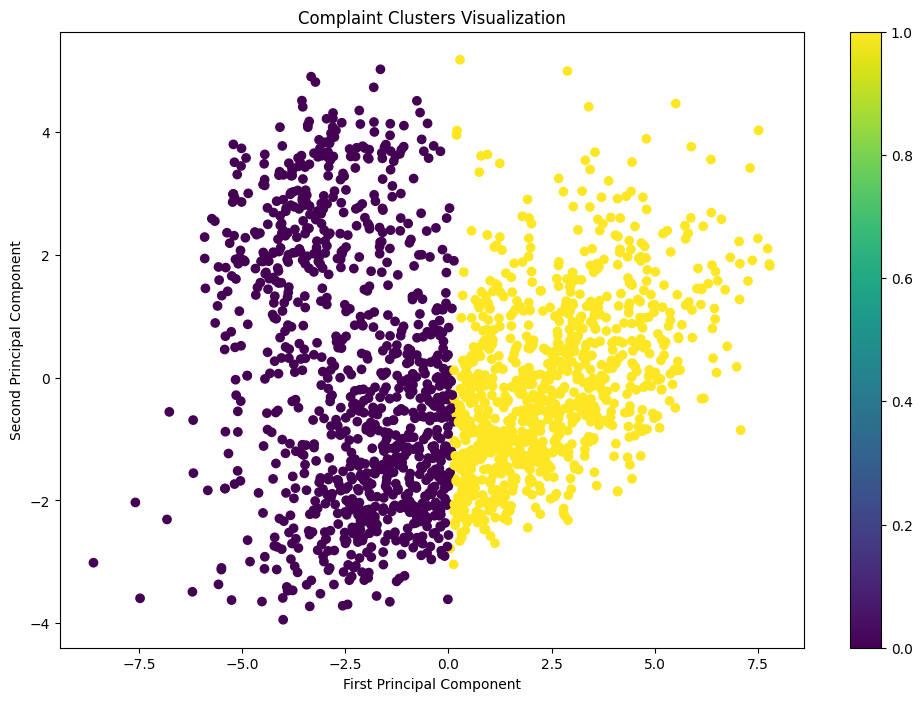

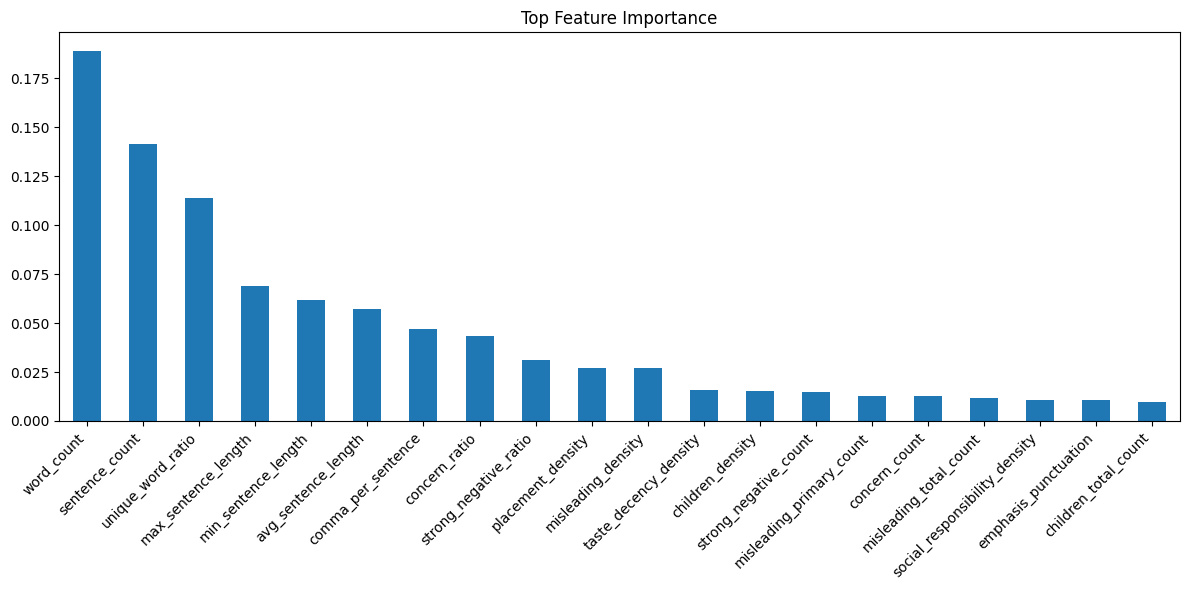

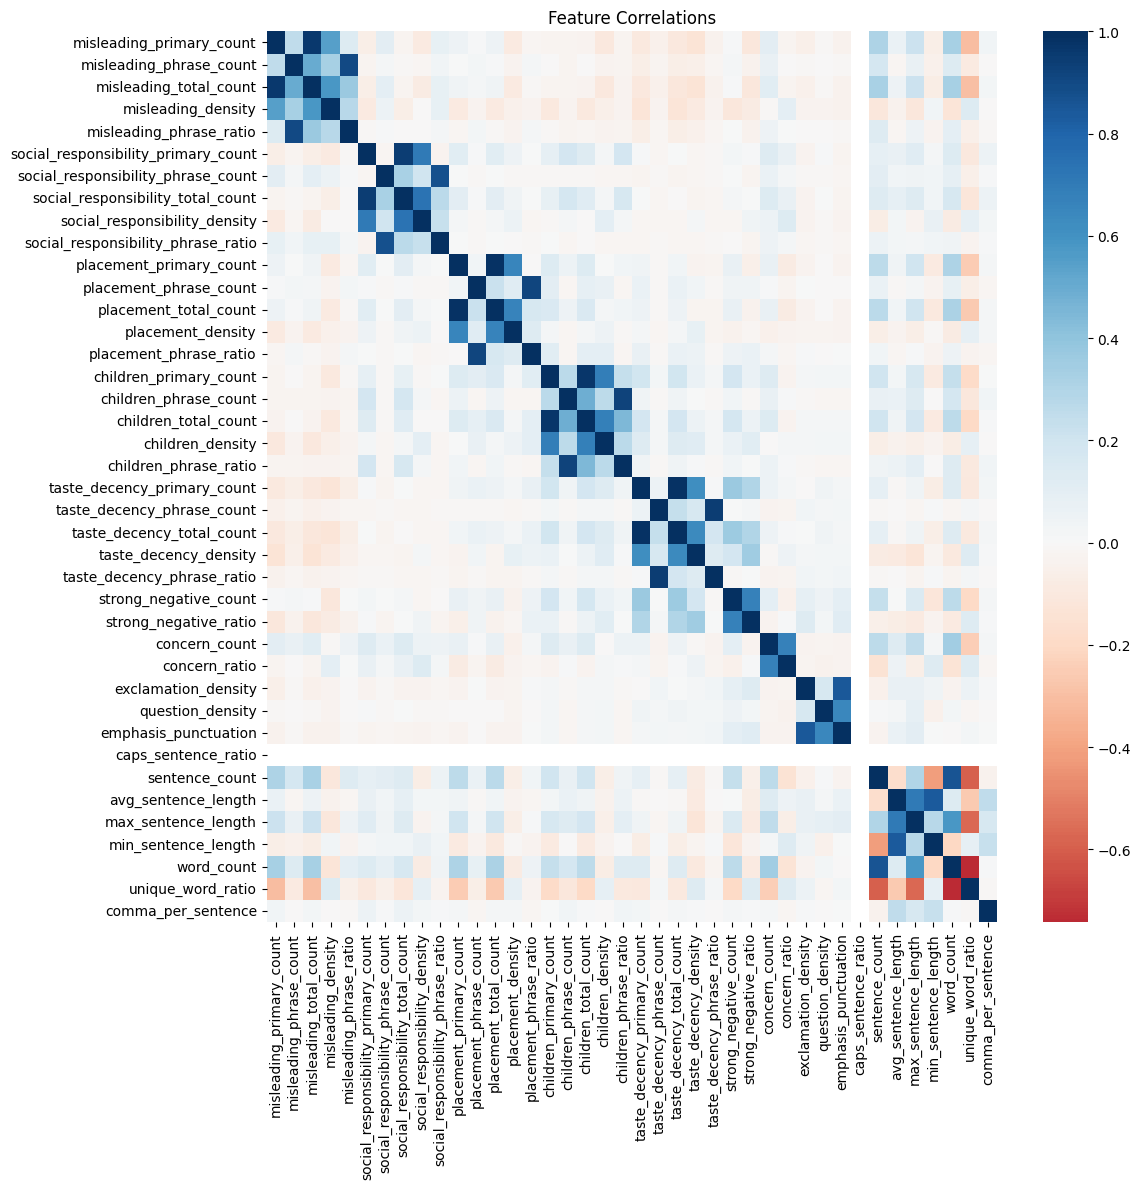

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import logging

class EnhancedComplaintAnalyzer:
    def __init__(self, bert_model='bert-base-uncased'):
        # BERT 初始化
        self.tokenizer = BertTokenizer.from_pretrained(bert_model)
        self.model = BertModel.from_pretrained(bert_model)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()

        # NLTK初始化
        nltk.download('stopwords')
        nltk.download('punkt')
        self.stop_words = set(stopwords.words('english'))

        # 特征提取器初始化
        self.feature_extractor = ImprovedAdComplaintFeatures()
    def get_cluster_keywords(self, texts, cluster_labels, top_n=10):
        """
        提取每个聚类最具代表性的关键词。

        参数：
            texts (pd.Series): 包含投诉文本的Series
            cluster_labels (np.array): 聚类分配的数组
            top_n (int): 每个聚类要提取的关键词数量

        返回：
            dict: 将聚类ID映射到其顶部关键词和得分的字典
        """
        cluster_keywords = {}
        texts = texts.fillna("")  # 处理任何NaN值

        # 处理每个聚类
        for cluster_id in np.unique(cluster_labels):
            # 获取该聚类中的所有文本
            cluster_texts = texts[cluster_labels == cluster_id]

            # 合并该聚类中的所有文本
            combined_text = " ".join(cluster_texts)

            # 分词和清理
            tokens = word_tokenize(combined_text.lower())

            # 删除停用词、标点符号和数字
            cleaned_tokens = [
                token for token in tokens
                if token not in self.stop_words
                and token.isalnum()  # 只保留字母数字标记
                and not token.isnumeric()  # 删除纯数字
                and len(token) > 2  # 删除很短的标记
            ]

            # 计算标记频率
            token_freq = Counter(cleaned_tokens)

            # 计算类TF-IDF分数
            # 我们将比较该聚类中的标记频率与其他聚类的频率
            cluster_size = len(cluster_texts)
            token_scores = {}

            for token, freq in token_freq.items():
                # 计算其他聚类中的标记频率
                other_clusters_freq = 0
                for other_cluster_id in np.unique(cluster_labels):
                    if other_cluster_id != cluster_id:
                        other_cluster_texts = texts[cluster_labels == other_cluster_id]
                        other_combined_text = " ".join(other_cluster_texts)
                        other_clusters_freq += other_combined_text.lower().count(token)

                # 计算重要性分数
                # 在此聚类中出现次数比其他聚类多的标记得分更高
                if other_clusters_freq == 0:
                    other_clusters_freq = 0.1  # 避免除以零

                score = (freq / cluster_size) / (other_clusters_freq / (len(texts) - cluster_size))
                token_scores[token] = score

            # 按分数获取顶部关键词
            top_keywords = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

            cluster_keywords[cluster_id] = {
                'keywords': [kw for kw, _ in top_keywords],
                'scores': [score for _, score in top_keywords]
            }

        return cluster_keywords
    def get_embeddings(self, texts, batch_size=32):
        """获取BERT嵌入向量"""
        embeddings = []

        processed_texts = [str(text) if not pd.isna(text) else "" for text in texts]

        for i in tqdm(range(0, len(processed_texts), batch_size), desc="Generating embeddings"):
            batch_texts = processed_texts[i:i + batch_size]
            encoded = self.tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors='pt'
            ).to(self.device)

            with torch.no_grad():
                outputs = self.model(**encoded)
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.extend(batch_embeddings)

        return np.array(embeddings)

    def analyze_complaints(self, df, text_column='complaints'):
        """主分析函数"""
        logging.info("开始分析投诉数据...")

        # 1. 特征提取
        logging.info("提取自定义特征...")
        features_df = self.feature_extractor.create_features(df, text_column)

        # 2. BERT嵌入
        logging.info("生成BERT嵌入向量...")
        embeddings = self.get_embeddings(df[text_column])

        # 3. 聚类分析
        logging.info("执行聚类分析...")
        optimal_clusters, silhouette_scores = self.find_optimal_clusters(embeddings)
        kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)

        # 4. 获取聚类关键词
        logging.info("提取聚类关键词...")
        cluster_keywords = self.get_cluster_keywords(df[text_column], cluster_labels)

        # 5. 特征重要性分析
        logging.info("分析特征重要性...")
        feature_importance = self.feature_extractor.analyze_features(features_df, cluster_labels)

        # 6. 结果可视化
        self.visualize_results(embeddings, cluster_labels, feature_importance)

        # 7. 保存结果
        results_df = df.copy()
        results_df['cluster'] = cluster_labels
        for feature_name in features_df.columns:
            results_df[f'feature_{feature_name}'] = features_df[feature_name]

        return {
            'results_df': results_df,
            'cluster_keywords': cluster_keywords,
            'feature_importance': feature_importance,
            'silhouette_scores': silhouette_scores
        }

    def find_optimal_clusters(self, embeddings, max_clusters=10):
        """寻找最优聚类数"""
        silhouette_scores = []

        for n_clusters in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            cluster_labels = kmeans.fit_predict(embeddings)
            score = silhouette_score(embeddings, cluster_labels)
            silhouette_scores.append(score)
            logging.info(f"Clusters: {n_clusters}, Silhouette Score: {score:.3f}")

        optimal_clusters = np.argmax(silhouette_scores) + 2
        return optimal_clusters, silhouette_scores

    def visualize_results(self, embeddings, cluster_labels, feature_importance):
        """结果可视化"""
        # 1. 聚类可视化
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)

        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                            c=cluster_labels, cmap='viridis')
        plt.colorbar(scatter)
        plt.title('Complaint Clusters Visualization')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.show()

        # 2. 特征重要性可视化
        plt.figure(figsize=(12, 6))
        feature_importance['top_features'].plot(kind='bar')
        plt.title('Top Feature Importance')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # 3. 特征相关性热力图
        plt.figure(figsize=(12, 12))
        sns.heatmap(feature_importance['feature_correlations'],
                   cmap='RdBu', center=0, annot=False)
        plt.title('Feature Correlations')
        plt.tight_layout()
        plt.show()

def analyze_complaints_file(file_path):
    """便捷的文件分析函数"""
    df = pd.read_csv(file_path)
    analyzer = EnhancedComplaintAnalyzer()
    results = analyzer.analyze_complaints(df)

    # 保存结果
    results['results_df'].to_csv('enhanced_complaints_analysis.csv', index=False)
    logging.info("分析完成，结果已保存到 'enhanced_complaints_analysis.csv'")

    return results

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)
    analyze_complaints_file('/content/drive/MyDrive/combination_excel_withoutnull_labeled.csv')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from tqdm import tqdm
import os
import json
from datetime import datetime

class ComplaintTripletDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        # 按类别组织数据，便于采样
        self.label_to_indices = {label: np.where(labels == label)[0]
                               for label in np.unique(labels)}

        # 记录每个类别的样本数量
        self.label_counts = {label: len(indices) for label, indices
                           in self.label_to_indices.items()}
        print("Label distribution:", self.label_counts)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        anchor_text = self.texts[idx]
        anchor_label = self.labels[idx]

        # 选择positive（同类别的随机样本）
        positive_idx = np.random.choice(self.label_to_indices[anchor_label])
        while positive_idx == idx and self.label_counts[anchor_label] > 1:
            positive_idx = np.random.choice(self.label_to_indices[anchor_label])
        positive_text = self.texts[positive_idx]

        # 选择negative（不同类别的随机样本）
        negative_label = np.random.choice(
            [l for l in np.unique(self.labels) if l != anchor_label]
        )
        negative_idx = np.random.choice(self.label_to_indices[negative_label])
        negative_text = self.texts[negative_idx]

        # Tokenize all texts
        encoded = {
            'anchor': self.tokenize_text(anchor_text),
            'positive': self.tokenize_text(positive_text),
            'negative': self.tokenize_text(negative_text),
            'label_encoder': self.label_encoder,
            'data': data
        }

    def predict(self, texts, return_prob=False):
        """预测新的投诉文本"""
        if self.model is None:
            raise ValueError("Model has not been trained yet!")

        embeddings = self.trainer.get_embeddings(texts)

        # 使用KNN进行预测
        from sklearn.neighbors import KNeighborsClassifier
        knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')

        # 使用训练数据拟合KNN
        train_embeddings = self.trainer.get_embeddings(
            self.last_training_data['train_texts']
        )
        knn.fit(train_embeddings, self.last_training_data['train_labels'])

        # 预测
        if return_prob:
            predictions = knn.predict_proba(embeddings)
            return {
                'labels': self.label_encoder.inverse_transform(
                    np.argmax(predictions, axis=1)
                ),
                'probabilities': predictions
            }
        else:
            predictions = knn.predict(embeddings)
            return self.label_encoder.inverse_transform(predictions)

    def evaluate_model(self, test_df, text_column='complaints', label_column='label'):
        """评估模型性能"""
        if self.model is None:
            raise ValueError("Model has not been trained yet!")

        # 预测测试数据
        predictions = self.predict(
            test_df[text_column].values, return_prob=True
        )

        # 计算评估指标
        true_labels = self.label_encoder.transform(test_df[label_column])
        pred_labels = self.label_encoder.transform(predictions['labels'])

        # 生成分类报告
        report = classification_report(
            true_labels,
            pred_labels,
            target_names=self.label_encoder.classes_,
            output_dict=True
        )

        # 绘制混淆矩阵
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(true_labels, pred_labels)
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            xticklabels=self.label_encoder.classes_,
            yticklabels=self.label_encoder.classes_
        )
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.close()

        return {
            'classification_report': report,
            'confusion_matrix': cm,
            'predictions': predictions
        }

    def save_model(self, path='complaint_classifier'):
        """保存模型和相关组件"""
        os.makedirs(path, exist_ok=True)

        # 保存模型状态
        torch.save(self.model.state_dict(),
                  os.path.join(path, 'model.pt'))

        # 保存标签编码器
        with open(os.path.join(path, 'label_encoder.json'), 'w') as f:
            json.dump({
                'classes_': self.label_encoder.classes_.tolist()
            }, f)

        # 保存配置信息
        config = {
            'model_type': 'ComplaintTripletModel',
            'embedding_dim': 128,
            'max_length': 512,
            'version': '1.0',
            'timestamp': datetime.now().isoformat()
        }
        with open(os.path.join(path, 'config.json'), 'w') as f:
            json.dump(config, f)

    def load_model(self, path='complaint_classifier'):
        """加载保存的模型"""
        # 加载配置
        with open(os.path.join(path, 'config.json'), 'r') as f:
            config = json.load(f)

        # 初始化模型
        self.model = ComplaintTripletModel(
            embedding_dim=config['embedding_dim']
        )

        # 加载模型状态
        self.model.load_state_dict(
            torch.load(os.path.join(path, 'model.pt'))
        )

        # 加载标签编码器
        with open(os.path.join(path, 'label_encoder.json'), 'r') as f:
            encoder_data = json.load(f)
            self.label_encoder.classes_ = np.array(encoder_data['classes_'])

        # 初始化训练器
        self.trainer = ComplaintTripletTrainer(
            self.model, self.tokenizer, self.device
        )

def main():
    """主函数示例"""
    # 设置日志
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )

    # 加载数据
    df = pd.read_csv('your_complaints.csv')

    # 初始化系统
    system = ComplaintAnalysisSystem()

    # 训练模型
    results = system.train_model(
        df,
        text_column='complaints',
        label_column='label',
        batch_size=32,
        epochs=10
    )

    # 评估模型
    eval_results = system.evaluate_model(df)

    # 保存模型
    system.save_model()

    # 示例预测
    new_complaints = [
        "This advertisement is misleading about the product benefits",
        "The ad placement near a school is inappropriate"
    ]
    predictions = system.predict(new_complaints, return_prob=True)

    for text, label, probs in zip(
        new_complaints,
        predictions['labels'],
        predictions['probabilities']
    ):
        print(f"\nComplaint: {text}")
        print(f"Predicted category: {label}")
        print("Probabilities:")
        for category, prob in zip(system.label_encoder.classes_, probs):
            print(f"  {category}: {prob:.3f}")

if __name__ == "__main__":
    main()': torch.tensor(anchor_label)
        }

        return encoded

    def tokenize_text(self, text):
        encoded = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {k: v.squeeze(0) for k, v in encoded.items()}

class ComplaintTripletModel(nn.Module):
    def __init__(self, bert_model='bert-base-uncased', embedding_dim=128, dropout_rate=0.1):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model)

        # 添加更复杂的映射层
        self.mapper = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, embedding_dim)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        embeddings = self.mapper(pooled_output)
        return F.normalize(embeddings, p=2, dim=1)

    def get_embeddings(self, text, tokenizer):
        encoded = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )
        encoded = {k: v.to(next(self.parameters()).device) for k, v in encoded.items()}

        with torch.no_grad():
            embeddings = self.forward(**encoded)
        return embeddings.cpu().numpy()

class TripletLoss(nn.Module):
    def __init__(self, margin=0.3, mining_method='hard'):
        super().__init__()
        self.margin = margin
        self.mining_method = mining_method

    def forward(self, anchor, positive, negative):
        if self.mining_method == 'hard':
            # 计算所有可能的距离
            dist_pos = (anchor - positive).pow(2).sum(1)

            # 为每个anchor找到最难的negative
            dist_neg = []
            for i in range(len(anchor)):
                other_neg = torch.cat([negative[:i], negative[i+1:]], 0)
                dist_to_negs = (anchor[i:i+1] - other_neg).pow(2).sum(1)
                dist_neg.append(torch.min(dist_to_negs))
            dist_neg = torch.stack(dist_neg)

            losses = F.relu(dist_pos - dist_neg + self.margin)
        else:
            # 普通的triplet loss
            dist_pos = (anchor - positive).pow(2).sum(1)
            dist_neg = (anchor - negative).pow(2).sum(1)
            losses = F.relu(dist_pos - dist_neg + self.margin)

        return losses.mean()

class ComplaintTripletTrainer:
    def __init__(self, model, tokenizer, device='cuda', embedding_dim=128):
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.device = device
        self.criterion = TripletLoss(mining_method='hard')
        self.embedding_dim = embedding_dim
        self.history = {'train_loss': [], 'val_loss': []}

    def train(self, train_texts, train_labels,
             val_texts=None, val_labels=None,
             batch_size=32, epochs=10, learning_rate=2e-5,
             save_dir='models'):

        os.makedirs(save_dir, exist_ok=True)
        train_dataset = ComplaintTripletDataset(train_texts, train_labels, self.tokenizer)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        optimizer = torch.optim.AdamW([
            {'params': self.model.bert.parameters(), 'lr': learning_rate},
            {'params': self.model.mapper.parameters(), 'lr': learning_rate * 10}
        ])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=2, verbose=True
        )

        best_val_loss = float('inf')
        best_model_path = None

        for epoch in range(epochs):
            # Training
            self.model.train()
            train_loss = 0
            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

            for batch in progress_bar:
                loss = self._process_batch(batch, optimizer)
                train_loss += loss
                progress_bar.set_postfix({'loss': loss})

            avg_train_loss = train_loss / len(train_loader)
            self.history['train_loss'].append(avg_train_loss)

            # Validation
            if val_texts is not None and val_labels is not None:
                val_loss = self.evaluate(val_texts, val_labels, batch_size)
                self.history['val_loss'].append(val_loss)
                scheduler.step(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    # Save best model
                    best_model_path = os.path.join(
                        save_dir,
                        f'best_model_epoch_{epoch+1}_loss_{val_loss:.4f}.pt'
                    )
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val_loss': val_loss,
                    }, best_model_path)

            self._plot_training_progress()

        return best_model_path

    def _process_batch(self, batch, optimizer):
        # 将数据移到设备上
        anchor_data = {k: v.to(self.device) for k, v in batch['anchor'].items()}
        positive_data = {k: v.to(self.device) for k, v in batch['positive'].items()}
        negative_data = {k: v.to(self.device) for k, v in batch['negative'].items()}

        # Forward pass
        anchor_embeddings = self.model(**anchor_data)
        positive_embeddings = self.model(**positive_data)
        negative_embeddings = self.model(**negative_data)

        # 计算损失
        loss = self.criterion(
            anchor_embeddings,
            positive_embeddings,
            negative_embeddings
        )

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    def _plot_training_progress(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_loss'], label='Training Loss')
        if self.history['val_loss']:
            plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.savefig('training_progress.png')
        plt.close()

    def evaluate(self, val_texts, val_labels, batch_size=32):
        """评估函数"""
        self.model.eval()
        val_dataset = ComplaintTripletDataset(val_texts, val_labels, self.tokenizer)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        total_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                loss = self._process_batch(batch, None)
                total_loss += loss

        return total_loss / len(val_loader)

    def get_embeddings(self, texts, batch_size=32):
        """批量生成嵌入向量"""
        self.model.eval()
        embeddings = []

        for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
            batch_texts = texts[i:i+batch_size]
            batch_embeddings = []

            for text in batch_texts:
                embedding = self.model.get_embeddings(text, self.tokenizer)
                batch_embeddings.append(embedding)

            embeddings.extend(batch_embeddings)

        return np.vstack(embeddings)

    def visualize_embeddings(self, embeddings, labels, label_names=None):
        """使用t-SNE可视化嵌入向量"""
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)

        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                            c=labels, cmap='tab10', alpha=0.6)

        if label_names is not None:
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                        markerfacecolor=scatter.cmap(scatter.norm(i)),
                                        label=name, markersize=10)
                             for i, name in enumerate(label_names)]
            plt.legend(handles=legend_elements)

        plt.title('t-SNE visualization of complaint embeddings')
        plt.savefig('embeddings_visualization.png')
        plt.close()

class ComplaintAnalysisSystem:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = None
        self.trainer = None
        self.label_encoder = LabelEncoder()

    def prepare_data(self, df, text_column='complaints', label_column='label'):
        """准备数据"""
        # 编码标签
        encoded_labels = self.label_encoder.fit_transform(df[label_column])

        # 分割数据
        train_df, val_df = train_test_split(
            df, test_size=0.2, random_state=42, stratify=encoded_labels
        )

        return {
            'train_texts': train_df[text_column].values,
            'train_labels': self.label_encoder.transform(train_df[label_column]),
            'val_texts': val_df[text_column].values,
            'val_labels': self.label_encoder.transform(val_df[label_column]),
            'label_names': self.label_encoder.classes_
        }
    def train_model(self, df, text_column='complaints', label_column='label',
                batch_size=32, epochs=10, learning_rate=2e-5):
    """训练模型主函数

    Args:
        df (pd.DataFrame): 包含文本和标签的数据框
        text_column (str): 文本列名
        label_column (str): 标签列名
        batch_size (int): 批次大小
        epochs (int): 训练轮数
        learning_rate (float): 学习率

    Returns:
        dict: 包含训练结果的字典
    """
    logging.info("开始模型训练...")

    # 准备数据
    data = self.prepare_data(df, text_column, label_column)
    self.last_training_data = data  # 保存用于后续预测

    # 初始化模型和训练器
    self.model = ComplaintTripletModel(embedding_dim=128)
    self.trainer = ComplaintTripletTrainer(
        model=self.model,
        tokenizer=self.tokenizer,
        device=self.device,
        embedding_dim=128
    )

    # 记录训练开始时间
    start_time = datetime.now()
    logging.info(f"Training started at {start_time}")

    # 训练模型
    best_model_path = self.trainer.train(
        train_texts=data['train_texts'],
        train_labels=data['train_labels'],
        val_texts=data['val_texts'],
        val_labels=data['val_labels'],
        batch_size=batch_size,
        epochs=epochs,
        learning_rate=learning_rate
    )

    # 记录训练结束时间
    end_time = datetime.now()
    training_duration = end_time - start_time
    logging.info(f"Training completed. Duration: {training_duration}")

    # 生成所有数据的嵌入向量
    logging.info("Generating embeddings for all data...")
    all_texts = df[text_column].values
    all_labels = self.label_encoder.transform(df[label_column])
    embeddings = self.trainer.get_embeddings(all_texts)

    # 可视化嵌入向量
    logging.info("Visualizing embeddings...")
    self.trainer.visualize_embeddings(
        embeddings=embeddings,
        labels=all_labels,
        label_names=data['label_names']
    )

    # 计算类内距离和类间距离
    logging.info("Computing intra and inter class distances...")
    distances = self._compute_class_distances(embeddings, all_labels)

    # 生成结果报告
    results = {
        'embeddings': embeddings,
        'best_model_path': best_model_path,
        'label_encoder': self.label_encoder,
        'data': data,
        'training_duration': str(training_duration),
        'distances': distances,
        'model_params': {
            'batch_size': batch_size,
            'epochs': epochs,
            'learning_rate': learning_rate,
            'embedding_dim': 128
        }
    }

    # 保存训练配置和结果
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    os.makedirs('training_results', exist_ok=True)

    with open(f'training_results/training_results_{timestamp}.json', 'w') as f:
        # 转换numpy数组为列表以便JSON序列化
        save_results = {
            k: v.tolist() if isinstance(v, np.ndarray) else v
            for k, v in results.items()
            if k not in ['embeddings', 'model', 'trainer', 'data']
        }
        json.dump(save_results, f, indent=4)

    logging.info("Training results saved successfully")
    return results

def _compute_class_distances(self, embeddings, labels):
    """计算类内和类间距离

    Args:
        embeddings (np.ndarray): 嵌入向量
        labels (np.ndarray): 标签

    Returns:
        dict: 包含距离统计的字典
    """
    unique_labels = np.unique(labels)
    n_classes = len(unique_labels)

    # 初始化距离统计
    distances = {
        'intra_class': [],  # 类内距离
        'inter_class': [],  # 类间距离
        'class_centers': {} # 类别中心
    }

    # 计算每个类别的中心
    for label in unique_labels:
        class_embeddings = embeddings[labels == label]
        class_center = np.mean(class_embeddings, axis=0)
        distances['class_centers'][str(label)] = class_center

        # 计算类内距离
        for emb in class_embeddings:
            dist = np.linalg.norm(emb - class_center)
            distances['intra_class'].append(float(dist))

    # 计算类间距离
    centers = np.array(list(distances['class_centers'].values()))
    for i in range(n_classes):
        for j in range(i + 1, n_classes):
            dist = np.linalg.norm(centers[i] - centers[j])
            distances['inter_class'].append(float(dist))

    # 计算统计量
    distances['statistics'] = {
        'avg_intra_class': float(np.mean(distances['intra_class'])),
        'std_intra_class': float(np.std(distances['intra_class'])),
        'avg_inter_class': float(np.mean(distances['inter_class'])),
        'std_inter_class': float(np.std(distances['inter_class'])),
    }

    return distances